# WATER BAG TIME SERIE CLASSIFICATION - Model Selection

---
## Define Functions

#### Change project root directory

In [1]:
cd ../

C:\Users\luisr\Desktop\Repositories\Data Science Projects\Hackaton COR IV - Centro de Operações do RJ\ACELERAÇÃO


#### Import modules and libraries

In [515]:
import os, json, pandas as pd, numpy as np, pickle
import matplotlib.pyplot as plt, seaborn as sns; sns.set()
from IPython.display import clear_output as co

#### Group related split, evaluation and probability methods (Authoral)
from Modulos.imbalanced_selection import groupConsecutiveFlags, MinorityGroupSplitUndersample, group_metrics, scoring
from Modulos.probability import predict_proba, scale_proba, clf_score, precision_recall_plot, groups_windows, window_prob, multi_window_prob

#### Preprocessing & machine learning modules
from sklearn.preprocessing import StandardScaler as ss, MinMaxScaler as mms, MaxAbsScaler as mas, PowerTransformer as pt
from sklearn.model_selection import cross_validate, cross_val_predict, GridSearchCV, TimeSeriesSplit
from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report as cr
from sklearn.utils import all_estimators
classifiers = dict(all_estimators('classifier'))

## Utility Funcitons

In [324]:
from sklearn.preprocessing import LabelEncoder as le

def custom_preprocessing(X, drop_empty_cols=False, label_encode=None, interpolate='linear', fillna='mean'):

    print('Initial shape:', X.shape)

    if drop_empty_cols: # Drop X empty columns and rows
        X.dropna(axis=1, how='all', inplace=True)
        print('Empty columns removed: ', X.shape)

    if label_encode is not None:
        print('Label columns encoded:', list(label_encode))
        LEi = {}
        for col in label_encode:
            LEi[col] = le().fit(X[col])
            X[col] = LEi[col].transform(X[col])

    if interpolate is not None: # Interpolate X missing values
        print('Interpolation:', interpolate)
        X = X.interpolate(interpolate)

    if fillna is not None: # Fill missing values with the minimum column value
        print('Fill missing values:', fillna)
        for col in X:
            if fillna=='min':
                fill_value = X[col].min()
            elif fillna=='mean':
                fill_value = X[col].mean()
            else:
                fill_value = 0
            X[col].fillna(fill_value, inplace=True)

    if label_encode is not None:
        return X, LEi
    return X

# Target selection and train/test split
def select_target(target_id, periods_ahead, shift=0):
    print(f'Selected Target: {target_names[int(target_id)]} - id: {target_id}', '\n')

    # Select target
    Y = Yi[str(target_id)].loc[X.index].copy()
    y_cnt = Y.value_counts().to_frame('Target')

    ### Target transformation
    if periods_ahead is not None:
        Y = (Y.rolling(periods_ahead, closed='left', min_periods=1).sum().shift(1 - periods_ahead) > 0).astype('float')
        print('Target range:', periods_ahead)
    if shift is not None:
        Y = Y.shift(shift)
        print('Target shift:', periods_ahead)

    y_cnt = pd.concat([y_cnt, Y.value_counts().to_frame('Transformed Target')], axis=1)

    # Group target positive class labels by being consecutive in time (group evaluation strategy)
    groups = groupConsecutiveFlags(ts=Y)
    
    return Y, groups, y_cnt

def time_serie_cross_validation_plot(scr_time, mean_1=None):
    scr_cols = np.array(['train_precision-1', 'train_recall-1', 'train_f1-1', 'test_precision-1', 'test_recall-1', 'test_f1-1'], dtype='object')
    stats_cols = ['mean', 'std', 'min', '50%', 'max']
    for col_type in ['', ' avg', ' group']:
        fig, ax = plt.subplots(1, 2, figsize=(18, 4))
        scr_time[scr_cols[3:6] + col_type].plot(marker='o', ms=5, ax=ax[0])
        scr_time[scr_cols[3:6] + col_type].rolling(100, min_periods=1).mean().plot(marker='o', ms=5, ax=ax[1])
        if mean_1 is not None:
            for i in range(len(ax)):
                mean_1.plot(linestyle='--', marker='.', ax=ax[i])
        plt.show()
    for col_type in ['', ' avg', ' group']:
        ### Average temporal performance
        display(scr_time.describe().loc[['mean', '50%', 'std'], scr_cols + col_type])
    return 

# from Modulos.imbalanced_selection import cross_val_predict_proba

def cross_val_predict_proba(estimator, X, Y, cv, calibrate=None):
    yprob_cv, fail = [], []
    for i, (train, test) in enumerate(cv):
        try:
            estimator.fit(X.iloc[train], Y.iloc[train])
            yprob = predict_proba(estimator, X.iloc[test])
            # Optional scale probabilities
            if calibrate is not None:
                yprob = scale_proba(yprob, threshold=calibrate, limit=None)
            yprob_cv.append(yprob.values)
        except Exception as e:
            yprob_cv.append(np.array([np.nan] * len(test)))
            fail.append(e)
        co(True); print(f'cv: {i+1}/{len(cv)}')
    if len(fail): print('Errors:', fail)
    return yprob_cv

---
## Load & Preprocess Data

In [4]:
from Modulos.waterbags import waterbag_project

project = waterbag_project(time_serie='clusters', freq='upsample', load_waterbags=True, time_features=True)

data = project.data
Yi = project.time_serie
waterbags = project.waterbags

# Sample groups names per group label
target_names = waterbags.groupby(['sublabel', 'main_route']).first().index.to_frame().set_index('sublabel').to_dict()['main_route']

# Drop specific columns from trining dataset
out_time = ['index', 'year', 'date']
out_stations = ['A652', 'A654']
out_inmet = [col for col in data if np.any([station in col for station in out_stations])]

out_cols = out_time + out_inmet
data.drop(out_cols, axis=1, inplace=True)

print('Dataset shape:', data.shape)

C:\Users\luisr\Desktop\Repositories\Data Science Projects\Hackaton COR IV - Centro de Operações do RJ\ACELERAÇÃO\Modulos\waterbags.py:63: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instead.
  upsample = inmet.resample('15Min').pad()


Dataset shape: (437875, 213)


---
# 1. Preprocessing & Data Transformation

## Preprocessing

In [5]:
label_cols = data.columns[:9]

transform_args = dict(
    label_encode=label_cols,
    interpolate='nearest', fillna='mean'
)

data_encoded, encoder = custom_preprocessing(data.copy(), **transform_args)

Initial shape: (437875, 213)
Label columns encoded: ['month', 'day', 'hour', 'minute', 'time', 'dayofyear', 'weekofyear', 'weekday', 'quarter']
Interpolation: nearest
Fill missing values: mean


### Target rolling proportion

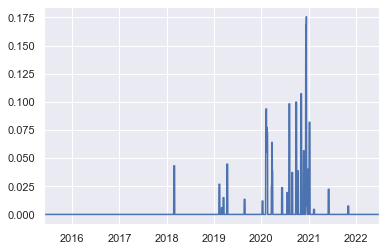

In [486]:
target_id = '4'
periods_ahead = 4

window = 7*24*4 
ax = Yi.loc['2015-06': , target_id].rolling(window).mean().plot()

### Feature set

In [733]:
n_splits = 5
train_start, train_end = '2020-01', '2020-12'
eval_start, eval_end = '2021-01', '2021-12'

X = data_encoded[train_start: eval_end].copy()

# Validation split
xt = X[train_start: train_end]
xe = X[eval_start: eval_end]

non_constant = X.columns[[len(X[col].unique()) != 1 for col in X.columns]]

### Target variable

In [735]:
Y, groups, y_cnt = select_target(target_id, periods_ahead, shift=0)

# Target validation split
yt = Y.loc[xt.index]
ye = Y.loc[xe.index]
groups_train = groups.loc[xt.index]
groups_eval = groups.loc[xe.index]

eval_p = (ye.value_counts() / Y.value_counts() * 100)
print(); display(eval_p.round(2).to_frame('Validation (%)'))

Selected Target: Avenida Ministro Ivan Lins - id: 4 

Target range: 4
Target shift: 4



,Validation (%)
0.0,50.37
1.0,11.35


---
# Baseline model and feature selection

### Selected model

In [705]:
import sklearn.neural_network as nn

rbm = nn.BernoulliRBM
mlp = nn.MLPClassifier

model = mlp(
    (100,), verbose=1, random_state=0, batch_size=200,
    early_stopping=True, validation_fraction=0.1,
    n_iter_no_change=5, tol=0.005, max_iter=50,
)

# Grid search tunning

### Time series cross-validation split

In [648]:
# Cross-validation split 
# n_splits = 5

splitter = TimeSeriesSplit(n_splits, max_train_size=None, test_size=None)
cv_time_full = list(splitter.split(X, Y))

for i in range(n_splits):  # Fill test folders
    cv_time_full[i] = (cv_time_full[i][0], np.arange(cv_time_full[i][1][0], len(X)))

### Pipeline definition

In [649]:
# Pipeline
column_trans = ColumnTransformer([('scale', mms(), non_constant)], remainder='drop')
rus = RandomUnderSampler(sampling_strategy=0.02, random_state=seed)
pipe = Pipeline([('scale', column_trans), ('under', rus), ('model', model)])

### Grid search hyperparameter tunning

In [523]:
# Parameter grid
param_grid = [{
    'under__sampling_strategy': np.arange(0.01, 0.065, 0.005),
#     'model__alpha': np.logspace(-6, -3.5, 20),
#     'model__tol': [0.01, 0.001, 0.0001],
}]

# Grid search
grid_search = GridSearchCV(
    pipe, param_grid, scoring=group_metrics.group_scorer, cv=cv_time_full,
    n_jobs=2, verbose=3, error_score=np.nan,
    return_train_score=True, refit=False,
)

grid_search = grid_search.fit(X, Y)
scr_grid = pd.DataFrame(grid_search.cv_results_)

Fitting 7 folds for each of 11 candidates, totalling 77 fits


### Average scores

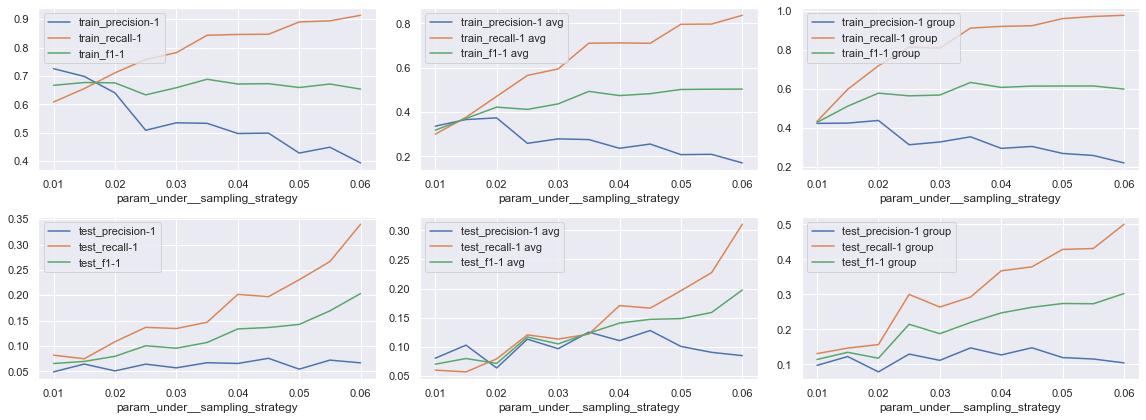

In [580]:
scr_cols = np.array(['train_precision-1', 'train_recall-1', 'train_f1-1', 'test_precision-1', 'test_recall-1', 'test_f1-1'], dtype='object')
stats_cols = ['mean', 'std', 'min', '50%', 'max']

param_name = 'param_under__sampling_strategy'
# param_name = 'param_model__alpha'
# param_name = 'param_model__tol'

fig, ax = plt.subplots(2, 3, figsize=(16, 6), tight_layout=True)

for i, col_type in enumerate(['', ' avg', ' group']):
    scr_mean = pd.concat([scr_grid[[f'split{i}_' + col for i in range(n_splits)]].mean(1).rename(col) for col in scr_cols + col_type], axis=1)
    scr_mean.index = scr_grid[param_name]
    scr_mean[scr_cols[:3] + col_type].plot(ax=ax[0][i])
    scr_mean[scr_cols[3:] + col_type].plot(ax=ax[1][i])

---
# Selected model evaluation

### Selected pipe parameters

In [706]:
Y.mean()

0.01130015959872321

In [727]:
seed = 0
selected_param = float(input('Under Sampling Strategy:'))

column_trans = ColumnTransformer([('scale', mms(), non_constant)], remainder='drop')
rus = RandomUnderSampler(sampling_strategy=selected_param, random_state=seed, replacement=False)
pipe = Pipeline([('scale', column_trans), ('under', rus), ('model', model)])

Under Sampling Strategy: 0.1


### Validation score

Iteration 1, loss = 0.28561257
Validation score: 0.927570
Iteration 2, loss = 0.15633683
Validation score: 0.936916
Iteration 3, loss = 0.13731562
Validation score: 0.943925
Iteration 4, loss = 0.12686670
Validation score: 0.946262
Iteration 5, loss = 0.11888318
Validation score: 0.946262
Iteration 6, loss = 0.11238491
Validation score: 0.953271
Iteration 7, loss = 0.10603495
Validation score: 0.953271
Iteration 8, loss = 0.10106637
Validation score: 0.957944
Iteration 9, loss = 0.09582789
Validation score: 0.955607
Iteration 10, loss = 0.09053388
Validation score: 0.962617
Iteration 11, loss = 0.08722799
Validation score: 0.960280
Iteration 12, loss = 0.08258703
Validation score: 0.964953
Validation score did not improve more than tol=0.005000 for 5 consecutive epochs. Stopping.
predict_proba method used.


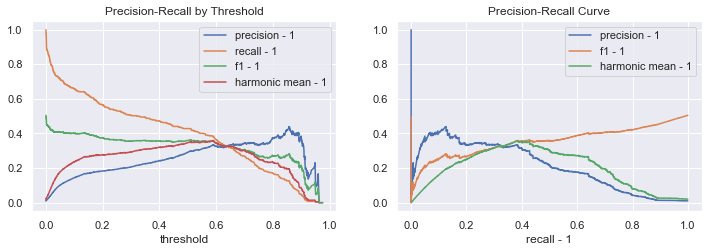

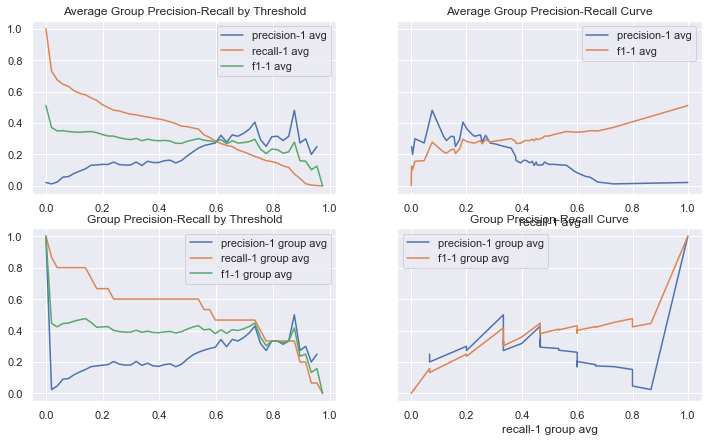

In [714]:
pipe.fit(xt, yt)

# Predict Probability
yprob = predict_proba(pipe, xe)

### Prediction evaluation
sel_thresh = 0.5
yhat = (yprob > sel_thresh).astype('int')
groups_hat = groupConsecutiveFlags(ts=yhat)

### Evaluate prediction
ax = precision_recall_plot(ye, yprob)
ax, grp_curve = group_metrics.group_precision_recall_plot(ye, yprob, groups_eval, num=50)

---
# Cross validation

### Time split

In [715]:
# n_splits = 7
splitter = TimeSeriesSplit(n_splits, max_train_size=None, test_size=None)
cv_time = list(splitter.split(X, Y))

### Concatenated splits' probabilities

cv: 5/5


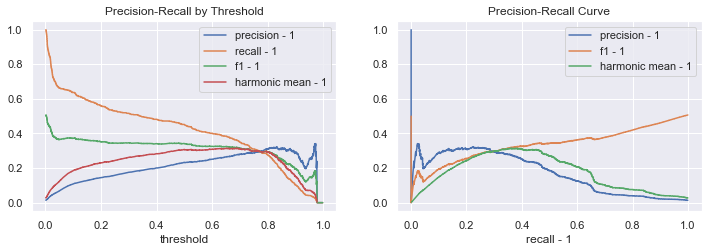

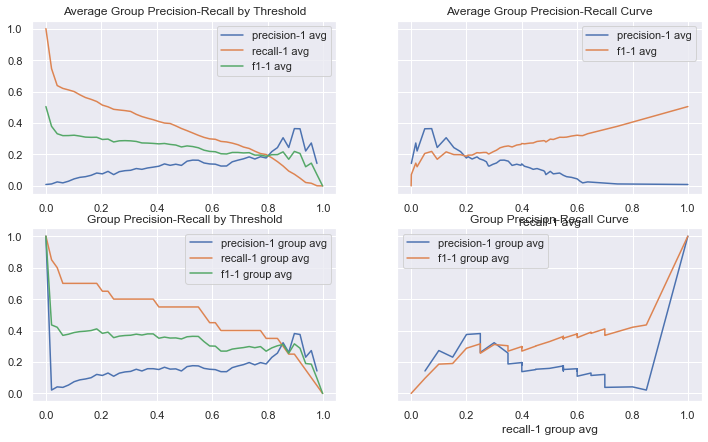

In [728]:
test_index = X.index[cv_time[0][1][0] :]
Ye = Y.loc[test_index]
groups_e = groups.loc[test_index]

yprob_cv = cross_val_predict_proba(pipe, X, Y, cv_time, calibrate=None)
yprob = pd.Series(np.concatenate(yprob_cv), index=test_index).dropna()

yhat = (yprob > 0.5).astype('float')
groups_hat = groupConsecutiveFlags(ts=yhat)

### Evaluate prediction
ax = precision_recall_plot(Ye.loc[yprob.index], yprob)
ax, grp_curve = group_metrics.group_precision_recall_plot(Ye.loc[yprob.index], yprob, groups_e.loc[yprob.index], num=50)

### Cross validation

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.4s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.5s finished


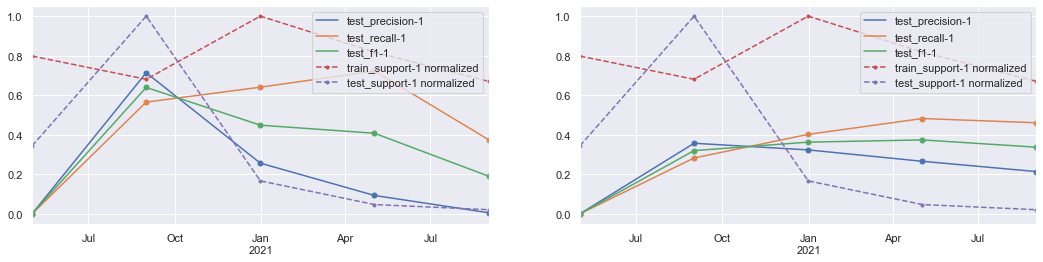

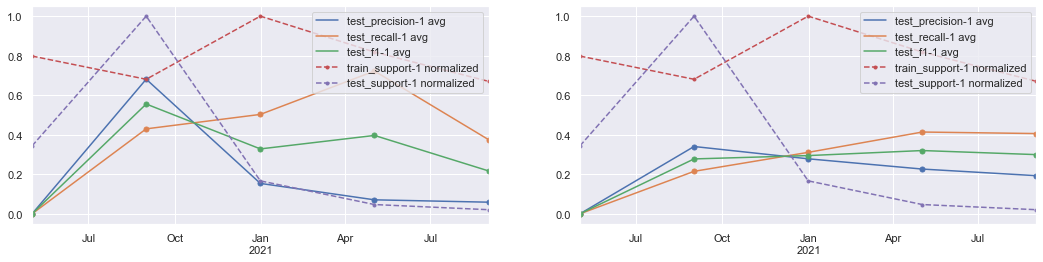

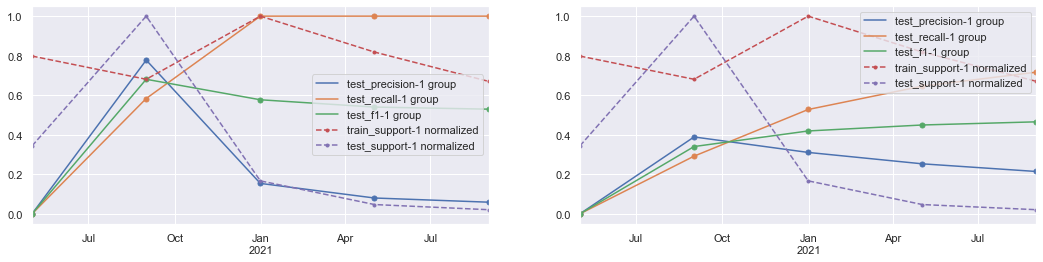

,train_precision-1,train_recall-1,train_f1-1,test_precision-1,test_recall-1,test_f1-1
mean,0.539539,0.792438,0.665988,0.213683,0.460590,0.337137
50%,0.477679,0.793103,0.647756,0.092857,0.565104,0.407540
std,0.158714,0.053874,0.096405,0.298139,0.287774,0.246972


,train_precision-1 avg,train_recall-1 avg,train_f1-1 avg,test_precision-1 avg,test_recall-1 avg,test_f1-1 avg
mean,0.321242,0.718044,0.519643,0.192879,0.405991,0.299435
50%,0.346984,0.703144,0.511235,0.070769,0.429860,0.328360
std,0.064699,0.046057,0.041882,0.278311,0.262558,0.207516


,train_precision-1 group,train_recall-1 group,train_f1-1 group,test_precision-1 group,test_recall-1 group,test_f1-1 group
mean,0.421009,0.879701,0.650355,0.214089,0.716667,0.465378
50%,0.431034,0.884615,0.662647,0.080000,1.000000,0.540000
std,0.056396,0.030196,0.036523,0.319881,0.439381,0.266922


In [717]:
# evaluate splits
scr_time = pd.DataFrame(cross_validate(
    pipe, X, Y, # groups=groups_train,
    scoring=group_metrics.group_scorer, cv=cv_time,
    return_train_score=True,
    error_score=np.nan,
    n_jobs=-1, verbose=5,
    pre_dispatch='2*n_jobs',
))

# Reset score index by test start
test_start = []
for train, test in cv_time:
    test_start.append(X.iloc[test].index.min())
scr_time.index = test_start

# Test class proportion
mean_1 = pd.DataFrame(
    mas().fit_transform([[Y[cv[0]].mean(), Y[cv[1]].mean()] for cv in cv_time]),
    columns=['train_support-1 normalized', 'test_support-1 normalized'], index=scr_time.index
)
not_null = ~mean_1.iloc[:, 0].isin([0])

### Temporal performance
time_serie_cross_validation_plot(scr_time, mean_1)

---
# Feature Selection

In [718]:
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer

### Feature importance with permutation score

In [719]:
# Pipeline
column_trans = ColumnTransformer([('scale', mms(), non_constant)], remainder='drop')
rus = RandomUnderSampler(sampling_strategy=selected_param, random_state=seed)
pipe = Pipeline([('scale', column_trans), ('under', rus), ('model', model)])

# Random group train test split
splitter = MinorityGroupSplitUndersample(
    n_splits=1,
    train_size=0.66, test_size=0.33,
    train_prct=None, test_prct='natural',
    random_state=seed,
)

cv_group = list(splitter.split(X, Y, groups, strategy='GroupShuffleSplit'))
t_ind, e_ind = cv_group[0]

# Permuation importance
pipe.fit(X.iloc[t_ind], Y.iloc[t_ind])

r = permutation_importance(pipe, X.iloc[e_ind], Y.iloc[e_ind], n_repeats=5,
                           scoring=scoring['f1-1'],
                           random_state=None, n_jobs=-1)

Iteration 1, loss = 0.25871774
Validation score: 0.935540
Iteration 2, loss = 0.14008911
Validation score: 0.951220
Iteration 3, loss = 0.12519236
Validation score: 0.949477
Iteration 4, loss = 0.11608908
Validation score: 0.947735
Iteration 5, loss = 0.10996433
Validation score: 0.947735
Iteration 6, loss = 0.10338838
Validation score: 0.949477
Iteration 7, loss = 0.09833867
Validation score: 0.949477
Iteration 8, loss = 0.09285842
Validation score: 0.944251
Validation score did not improve more than tol=0.005000 for 5 consecutive epochs. Stopping.


In [720]:
fi = pd.Series(r['importances_mean'], index=xt.columns).sort_values(ascending=False)
selected_columns = fi.index[fi > 0]; print('Selected Features:', f'{len(selected_columns)}/{xt.shape[1]}')

Selected Features: 37/213


### Selected pipe parameters

In [721]:
column_trans = ColumnTransformer([('scale', mms(), selected_columns)], remainder='drop')
rus = RandomUnderSampler(sampling_strategy=selected_param, random_state=seed)
pipe = Pipeline([('scale', column_trans), ('under', rus), ('model', model)])

### Validation score

Iteration 1, loss = 0.46622568
Validation score: 0.908879
Iteration 2, loss = 0.32418812
Validation score: 0.908879
Iteration 3, loss = 0.28161042
Validation score: 0.908879
Iteration 4, loss = 0.26391177
Validation score: 0.908879
Iteration 5, loss = 0.25225193
Validation score: 0.908879
Iteration 6, loss = 0.24283465
Validation score: 0.913551
Iteration 7, loss = 0.23466971
Validation score: 0.915888
Validation score did not improve more than tol=0.005000 for 5 consecutive epochs. Stopping.
predict_proba method used.


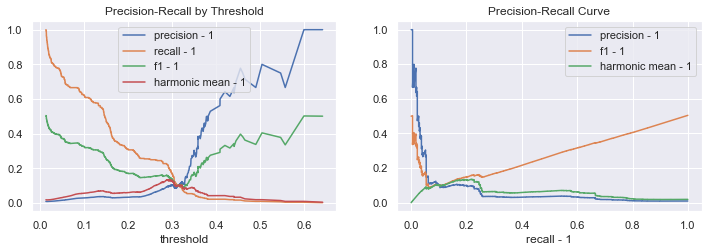

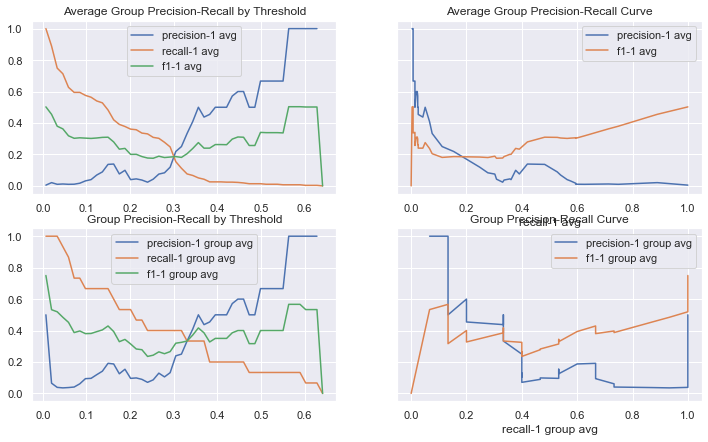

In [722]:
pipe.fit(xt, yt)

# Predict Probability
yprob = predict_proba(pipe, xe)

### Prediction evaluation
sel_thresh = 0.5
yhat = (yprob > sel_thresh).astype('int')
groups_hat = groupConsecutiveFlags(ts=yhat)

### Evaluate prediction
ax = precision_recall_plot(ye, yprob)
ax, grp_curve = group_metrics.group_precision_recall_plot(ye, yprob, groups_eval, num=50)

### Concatenated splits' probabilities

cv: 5/5


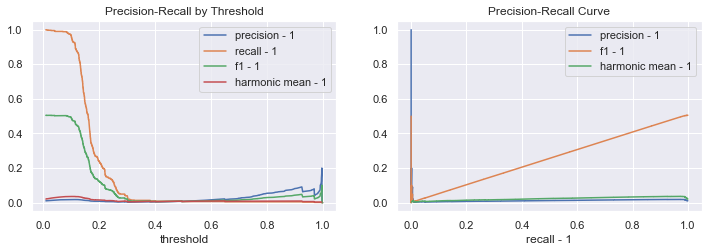

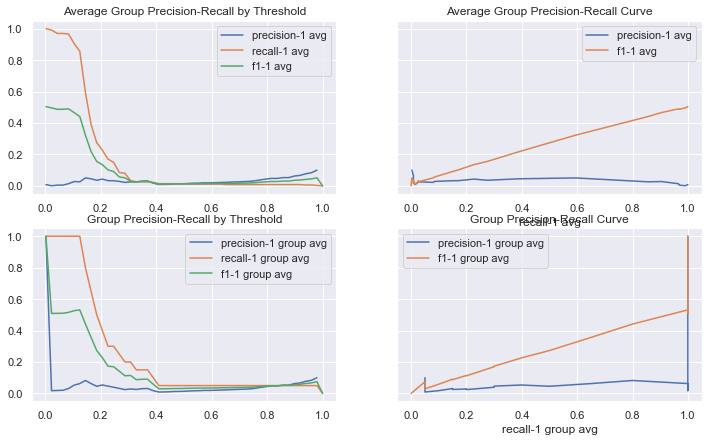

In [723]:
test_index = X.index[cv_time[0][1][0] :]
Ye = Y.loc[test_index]
groups_e = groups.loc[test_index]

yprob_cv = cross_val_predict_proba(pipe, X, Y, cv_time, calibrate=None)
yprob = pd.Series(np.concatenate(yprob_cv), index=test_index).dropna()

yhat = (yprob > 0.5).astype('float')
groups_hat = groupConsecutiveFlags(ts=yhat)

### Evaluate prediction
ax = precision_recall_plot(Ye.loc[yprob.index], yprob)
ax, grp_curve = group_metrics.group_precision_recall_plot(Ye.loc[yprob.index], yprob, groups_e.loc[yprob.index], num=50)

### Cross validation

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.3s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.4s finished


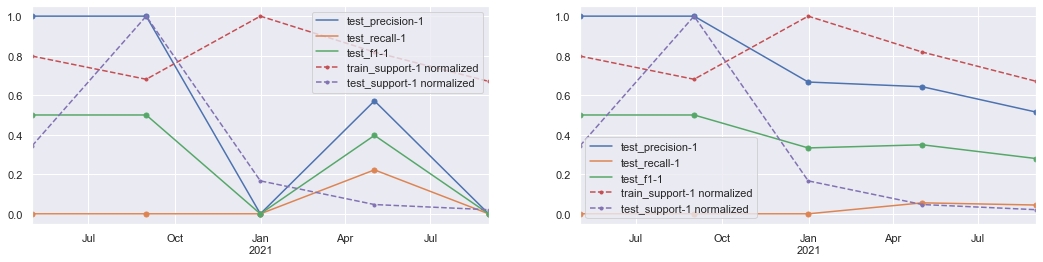

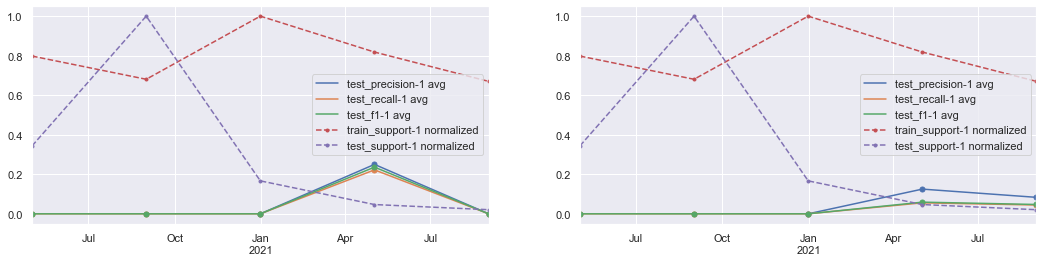

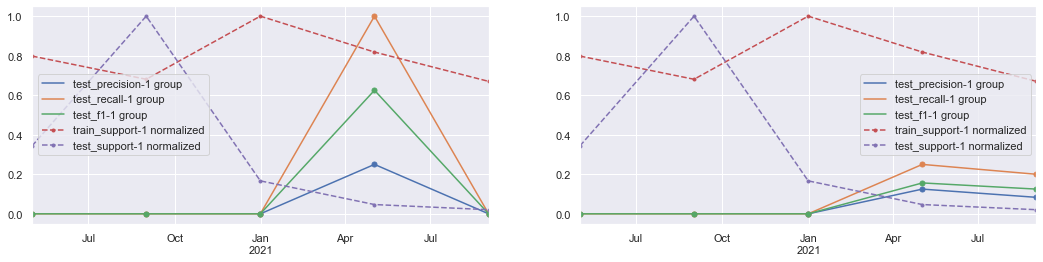

,train_precision-1,train_recall-1,train_f1-1,test_precision-1,test_recall-1,test_f1-1
mean,0.753923,0.219963,0.486943,0.514286,0.044444,0.279365
50%,0.788462,0.116643,0.500000,0.571429,0.000000,0.396825
std,0.256132,0.255881,0.022779,0.501019,0.099381,0.258479


,train_precision-1 avg,train_recall-1 avg,train_f1-1 avg,test_precision-1 avg,test_recall-1 avg,test_f1-1 avg
mean,0.426060,0.181753,0.218695,0.083333,0.044444,0.047222
50%,0.284737,0.091572,0.321421,0.000000,0.000000,0.000000
std,0.261937,0.213434,0.202083,0.144338,0.099381,0.105592


,train_precision-1 group,train_recall-1 group,train_f1-1 group,test_precision-1 group,test_recall-1 group,test_f1-1 group
mean,0.452712,0.386040,0.328834,0.083333,0.200000,0.125000
50%,0.323529,0.500000,0.469457,0.000000,0.000000,0.000000
std,0.240085,0.369962,0.304639,0.144338,0.447214,0.279508


In [724]:
# evaluate splits
scr_time = pd.DataFrame(cross_validate(
    pipe, X, Y, # groups=groups_train,
    scoring=group_metrics.group_scorer, cv=cv_time,
    return_train_score=True,
    error_score='raise',
    n_jobs=-1, verbose=5,
    pre_dispatch='2*n_jobs',
))

# Reset score index by test start
test_start = []
for train, test in cv_time:
    test_start.append(X.iloc[test].index.min())
scr_time.index = test_start

# Test class proportion
mean_1 = pd.DataFrame(
    mas().fit_transform([[Y[cv[0]].mean(), Y[cv[1]].mean()] for cv in cv_time]),
    columns=['train_support-1 normalized', 'test_support-1 normalized'], index=scr_time.index
)
not_null = ~mean_1.iloc[:, 0].isin([0])

# Temporal performance
time_serie_cross_validation_plot(scr_time, mean_1)

---
# Save model

In [725]:
def save_model(model, path, model_id, model_name=None):
    if not os.path.exists(path):
        os.makedirs(path)
    model_file = path + model_id + '.pickle'
    pickle.dump(model, open(model_file, 'wb'))
    print(f'Model saved: {model_id}')

def save_json(obj, path):
    with open(path, 'w') as file:
        file.write(json.dumps(obj))
    print('Done!')

### Fit selected pipeline

In [736]:
column_trans = ColumnTransformer([('scale', mms(), non_constant)], remainder='drop')
# column_trans = ColumnTransformer([('scale', mms(), selected_columns)], remainder='drop')
rus = RandomUnderSampler(sampling_strategy=selected_param, random_state=seed)
pipe = Pipeline([('scale', column_trans), ('under', rus), ('model', model)])

pipe['model'].set_params(verbose=0)
pipe.fit(X, Y)

Pipeline(steps=[('scale',
                 ColumnTransformer(transformers=[('scale', MinMaxScaler(),
                                                  Index(['month', 'day', 'hour', 'minute', 'time', 'dayofyear', 'weekofyear',
       'weekday', 'quarter', 'acumulado_chuva_1_h - A602',
       ...
       'acumulado_chuva_4_h - 32', 'acumulado_chuva_24_h - 32',
       'acumulado_chuva_15_min - 32', 'acumulado_chuva_1_h - 32',
       'acumulado_chuva_96_h - 32', 'acumulado_chuva_4_h - 33',
       'acumulado_chuva_24_h - 33', 'acumulado_chuva_15_min - 33',
       'acumulado_chuva_1_h - 33', 'acumulado_chuva_96_h - 33'],
      dtype='object', length=213))])),
                ('under',
                 RandomUnderSampler(random_state=0, sampling_strategy=0.1)),
                ('model',
                 MLPClassifier(batch_size=200, early_stopping=True, max_iter=50,
                               n_iter_no_change=5, random_state=0, tol=0.005,
                               verbose=0))])

### Save model + info

In [737]:
selected_threshold = float(input('Selected decision threshold:'))

model_path = f'API Deploy/Modelos/{target_id}/'
model_info = {
    'id': target_id,
    'name': target_names[int(target_id)],
    'threshold': selected_threshold
}

save_model(pipe, model_path, target_id)
save_json(model_info, model_path + 'info.json')

Selected decision threshold: 0.5


Model saved: 4
Done!


### Save encoders

In [253]:
path = f'API Deploy/Encoders/'

if not os.path.exists(path):
    os.makedirs(path)

for key in encoder:
    save_model(encoder[key], path, key)

Model saved: month
Model saved: day
Model saved: hour
Model saved: minute
Model saved: time
Model saved: dayofyear
Model saved: weekofyear
Model saved: weekday
Model saved: quarter


### Save features info

In [254]:
data_encoded.mean().to_frame('mean').to_csv('API Deploy/feature_info.csv')

data_encoded.shape

(437875, 213)

---
# Printing probabities

In [689]:
def groups_windows(groups, spread=6, freq=pd.Timedelta(1, 'h')):
    windows = []; wide = spread * freq
    for group in groups.unique():
        group_index = groups.index[groups==group]
        grp_min, grp_max = group_index.min(), group_index.max()
        windows.append((grp_min - wide, grp_max + wide))
    return windows

def window_prob(ye, yprob, time_lim, ax=None):
    yprob = pd.Series(mms().fit_transform(yprob.to_frame()).reshape(-1), index=yprob.index) # scale probability to 0-1 range
    msk = ye.index.to_series().between(*time_lim) # time window limits
    if ax is None: ax = plt.axes()
    yprob[msk].plot(ax=ax)
    ax = ye[msk].plot(ax=ax)
    return ax

def multi_window_prob(ye, yprob, windows, n_cols, title='Probability {} - {}', path=None):
    n_plots = len(windows)
    n_rows = int(n_plots / n_cols if n_plots % n_cols == 0 else n_plots // n_cols + 1)
    figsize = (6 * n_cols, 4 * n_rows)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize, tight_layout=True, sharey=True)
    axs = list(axs.reshape(-1))
    i=0
    for ax, time_lim in zip(axs, windows):
        i+=1; co(wait=True); print(f'{i}/{len(windows)}')
        msk = ye.index.to_series().between(time_lim[0], time_lim[1]) # time window limits
        yprob[msk].plot(ax=ax)
        ye[msk].plot(ax=ax)
        time_min, time_max = (time_lim[j].strftime('%d-%h-%y %H:%m') for j in (0, 1))
        ax.set(title=title.format(time_min, time_max))
    if path is not None: plt.savefig(path)
    return fig, axs

92/92


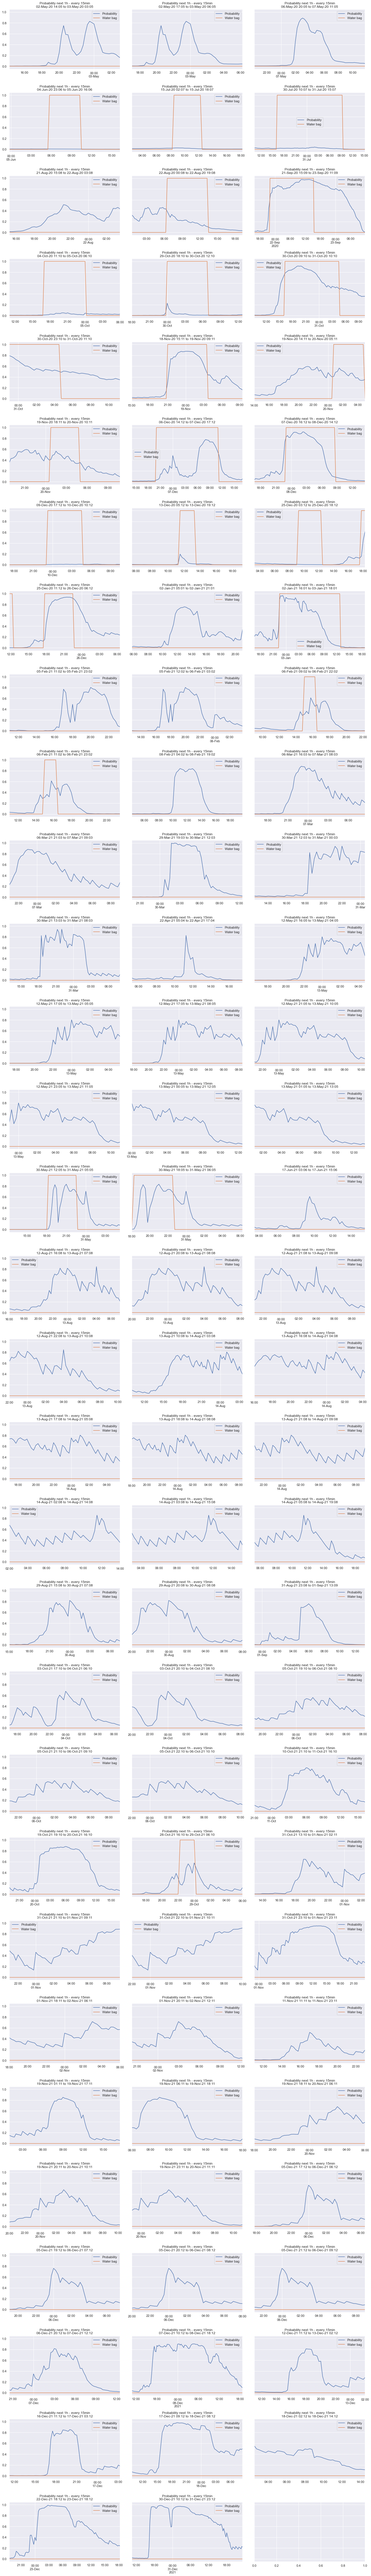

In [731]:
yhat = (yprob > selected_threshold).astype('float')

Y_positive = ((Ye + yhat) > 0.0).astype('float')
groups_positive = groupConsecutiveFlags(Y_positive)

windows =  groups_windows(groups_positive[groups_positive!=-1], spread=6, freq=pd.Timedelta(1, 'h'))

n_cols = 3
title = 'Probability next 1h - every 15min\n{} to {}'
path = f'Modelagem de Bolsões/Scores/Probabilidade/Prob-{target_id}.pdf'
# path = None

fig, axs = multi_window_prob(
    Ye.to_frame('Water bag'),
    yprob.to_frame('Probability'),
    windows, n_cols, title, path,
)

---
# Extra: Classifier Selection

In [567]:
models = ['AdaBoostClassifier', 'BaggingClassifier', 'BernoulliNB', 'CalibratedClassifierCV']
models = [classifiers[mdl] for mdl in models]

In [568]:
seed = 0

from sktime.classification.interval_based import (
    TimeSeriesForestClassifier as tsfc,
    RandomIntervalSpectralEnsemble as rise
)

# models = models + [tsfc, rise]
for i, mdl in enumerate(models):
    try:
        models[i] = mdl()
    except:
        try:
            models[i] = mdl(model)
        except Exception as e:
            print(e)

### Time series cross-validation split

In [569]:
# Cross-validation split 
# n_splits = 5

splitter = TimeSeriesSplit(n_splits, max_train_size=None, test_size=None)
cv_time = list(splitter.split(X, Y))

for i in range(n_splits):  # Fill test folders
    cv_time[i] = (cv_time[i][0], np.arange(cv_time[i][1][0], len(X)))

### Pipeline definition

In [570]:
# Pipeline
column_trans = ColumnTransformer([('scale', mms(), non_constant)], remainder='drop')
rus = RandomUnderSampler(sampling_strategy=selected_param, random_state=seed)
pipe = Pipeline([('scale', column_trans), ('under', rus), ('model', model)])

### Grid search hyperparameter tunning

In [ ]:
# Parameter grid
param_grid = [{'model': models[:5]}]

# Grid search
grid_search = GridSearchCV(
    pipe, param_grid, scoring=group_metrics.group_scorer, cv=cv_time,
    n_jobs=2, verbose=3, error_score=np.nan,
    return_train_score=True, refit=False,
)

grid_search = grid_search.fit(X, Y)

In [564]:
models[:5]

[AdaBoostClassifier(),
 BaggingClassifier(),
 BernoulliNB(),
 CalibratedClassifierCV(),
 CategoricalNB()]

In [575]:
scr_grid = pd.DataFrame(grid_search.cv_results_)

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

### Average scores

In [ ]:
scr_cols = np.array(['train_precision-1', 'train_recall-1', 'train_f1-1', 'test_precision-1', 'test_recall-1', 'test_f1-1'], dtype='object')
stats_cols = ['mean', 'std', 'min', '50%', 'max']

param_name = 'param_under__sampling_strategy'
# param_name = 'param_model__alpha'
# param_name = 'param_model__tol'

fig, ax = plt.subplots(2, 3, figsize=(16, 6), tight_layout=True)

for i, col_type in enumerate(['', ' avg', ' group']):
    scr_mean = pd.concat([scr_grid[[f'split{i}_' + col for i in range(n_splits)]].mean(1).rename(col) for col in scr_cols + col_type], axis=1)
    scr_mean.index = scr_grid[param_name]
    scr_mean[scr_cols[:3] + col_type].plot(ax=ax[0][i])
    scr_mean[scr_cols[3:] + col_type].plot(ax=ax[1][i])